# BERT Fine-Tuning Sentence Classification
Copyright 2020 Denis Rothman. The text cells were taken out and replaced by titles of each cell withing the cell. The titles of the cells refer to the titles of the sections of the book. The descriptions of the cells have been rewritten for educational purposes.

Contributer: George Mihaila

[Reference Notebook by Chris McCormick and Nick Ryan](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX)

[Reference Article by Chris McCormick and Nick Ryan](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

In [1]:
#@title Activating the GPU
# Main menu->Runtime->Change Runtime Type
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#@title Installing the Hugging Face PyTorch Interface for Bert
# !pip install pytorch-pretrained-bert pytorch-nlp
!pip install -q transformers

In [3]:
#@title Importing the modules
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
#% matplotlib inline

In [4]:
#@title Specifying CUDA as the device for Torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')



In [6]:
#!pwd

@article{warstadt2018neural,
    title={Neural Network Acceptability Judgments},
    author={Warstadt, Alex and Singh, Amanpreet and Bowman, Samuel R},
    journal={arXiv preprint arXiv:1805.12471},
    year={2018}
}


In [ ]:
#%cd /content/drive/MyDrive/Transformers-for-Natural-Language-Processing/Chapter02

#%pwd
#%ls

In [ ]:
#@title Loading the Dataset
#source of dataset : https://nyu-mll.github.io/CoLA/
#df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
#df = pd.read_csv("IMDB Dataset.csv", nrows = 2000)


#df.shape


In [7]:
#df = pd.read_csv("UpdatedResumeDataSet.csv")

# Load the dataframes
df_names = pd.read_csv('processed_names.csv')
df_resumes = pd.read_csv('UpdatedResumeDataSet.csv')

In [8]:
# Check if the indices are aligned; if not, this code will need adjusting
for i in range(len(df_names)):
    if i < len(df_resumes):
        # Ensure the Description ends with a period before appending
        description_with_period = df_names.loc[i, 'Description'].strip()
        if not description_with_period.endswith('.'):
            description_with_period += '.'

        # Prepend the Description to the Resume text
        df_resumes.loc[i, 'Resume'] = description_with_period + " " + df_resumes.loc[i, 'Resume']

# Save the updated dataframe back to the original CSV
df_resumes.to_csv('UpdatedResumeDataSet.csv', index=False)


In [9]:
df = pd.read_csv("UpdatedResumeDataSet.csv")

In [10]:
df.head()

,Category,Resume
0,Data Science,"I am Takashi, I am 55 years old and I am Japan..."
1,Data Science,"I am Ice, I am 54 years old and I am American...."
2,Data Science,"I am Edana, I am 34 years old and I am German...."
3,Data Science,"I am Nequiel, I am 59 years old and I am Ameri..."
4,Data Science,"I am Alijah, I am 31 years old and I am Americ..."


In [11]:
len(df)

962

In [12]:
df.tail()

,Category,Resume
957,Testing,"I am Jariath, I am 27 years old and I am Ameri..."
958,Testing,"I am Nomasonto, I am 52 years old and I am Afr..."
959,Testing,"I am Pranet, I am 44 years old and I am Indian..."
960,Testing,"I am Akio, I am 62 years old and I am Japanese..."
961,Testing,"I am Sonny, I am 26 years old and I am America..."


In [13]:
df.shape

(962, 2)

In [14]:
df['Category'].value_counts()

Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64

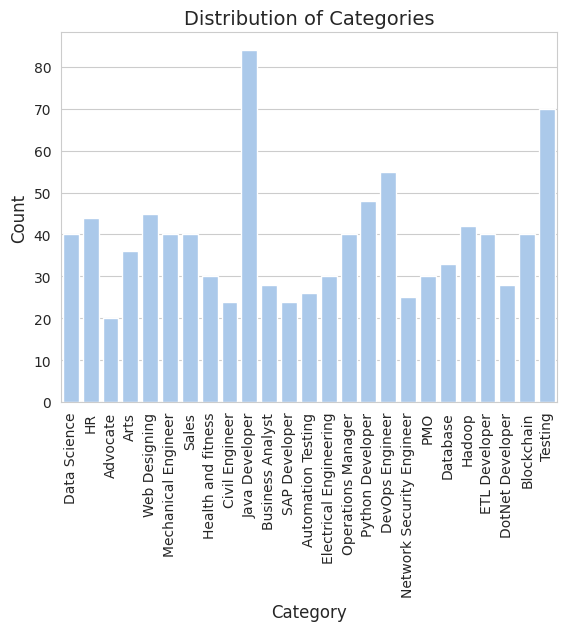

In [16]:
import seaborn as sns
# Set the style
sns.set_style("whitegrid")

# Set the color palette
sns.set_palette("pastel")

# Plot the countplot
sns.countplot(data=df, x='Category')

# Set labels and title
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Categories', fontsize=14)

# Rotate x-axis labels for better readability (if needed)
plt.xticks(rotation=90)

# Show the plot
plt.show()

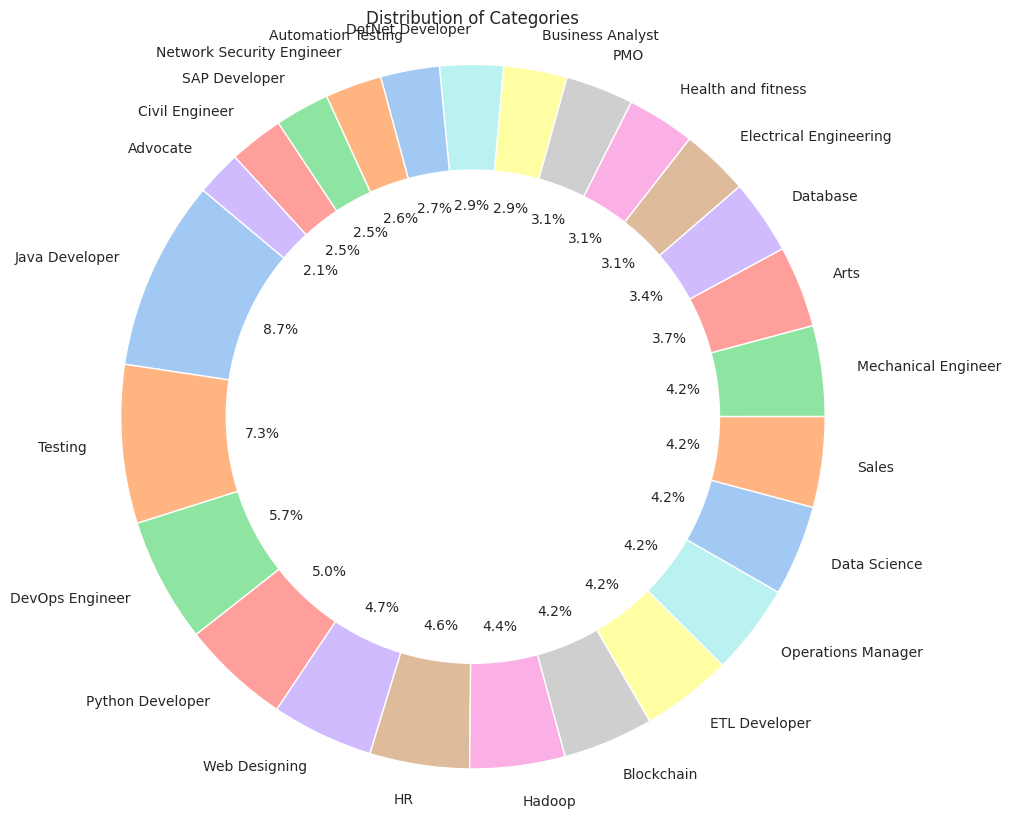

In [ ]:
# Get the count of each category
category_counts = df['Category'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)

# Draw circle to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('Distribution of Categories')

# Display the pie chart
plt.show()

In [17]:
df['Category'][0]

'Data Science'

In [18]:
df['Resume'][0]

'I am Takashi, I am 55 years old and I am Japanese. Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details \r\n\r\nData Science Assurance Associate \r\n\r\nData Science Assurance Associate - Ernst & Young LLP\r\nSkill Details \r\nJAVASCRIPT- Exprience - 24 months\r\njQuery- Exprience - 24 months\r\nPython- Exprience - 24 monthsCompany Details \r\ncompany - Er

In [ ]:
#@ Creating sentence, label lists and adding Bert tokens
#sentences = df.Resume.values
#OR:
#sentences = df.sentence
#type(sentences[0])

In [ ]:
###df1= df.copy()

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [20]:
df['Category_orig'] = df['Category']
le.fit(df['Category'])

df['Category'] = le.transform(df['Category'])

In [21]:
df.head()


,Category,Resume,Category_orig
0,6,"I am Takashi, I am 55 years old and I am Japan...",Data Science
1,6,"I am Ice, I am 54 years old and I am American....",Data Science
2,6,"I am Edana, I am 34 years old and I am German....",Data Science
3,6,"I am Nequiel, I am 59 years old and I am Ameri...",Data Science
4,6,"I am Alijah, I am 31 years old and I am Americ...",Data Science


In [ ]:
#df1.head()

In [22]:
df.tail(5)

,Category,Resume,Category_orig
957,23,"I am Jariath, I am 27 years old and I am Ameri...",Testing
958,23,"I am Nomasonto, I am 52 years old and I am Afr...",Testing
959,23,"I am Pranet, I am 44 years old and I am Indian...",Testing
960,23,"I am Akio, I am 62 years old and I am Japanese...",Testing
961,23,"I am Sonny, I am 26 years old and I am America...",Testing


In [23]:
# Optional: Create a mapping table for class numbers and original classes directly from the DataFrame
mapping_table = pd.DataFrame({
    'Category': df['Category'],  # Numeric categories
    'Category_orig': df['Category_orig']  # Original class labels
}).drop_duplicates().sort_values('Category').reset_index(drop=True)

# Optional: Display the mapping table
print(mapping_table)

    Category              Category_orig
0          0                   Advocate
1          1                       Arts
2          2         Automation Testing
3          3                 Blockchain
4          4           Business Analyst
5          5             Civil Engineer
6          6               Data Science
7          7                   Database
8          8            DevOps Engineer
9          9           DotNet Developer
10        10              ETL Developer
11        11     Electrical Engineering
12        12                         HR
13        13                     Hadoop
14        14         Health and fitness
15        15             Java Developer
16        16        Mechanical Engineer
17        17  Network Security Engineer
18        18         Operations Manager
19        19                        PMO
20        20           Python Developer
21        21              SAP Developer
22        22                      Sales
23        23                    Testing


In [24]:

from sklearn.model_selection import StratifiedShuffleSplit

# Load your dataset
#df = pd.read_csv("UpdatedResumeDataSet.csv")

# Define the split - 90% training, 10% test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

# Perform the split
for train_index, test_index in splitter.split(df, df['Category']):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]

# Save the datasets to new CSV files
train_df.to_csv("train_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)


In [25]:
df_train=pd.read_csv("train_dataset.csv")

In [26]:
df_test=pd.read_csv("test_dataset.csv")

In [27]:
df_train.head()

,Category,Resume,Category_orig
0,13,"I am Novak, I am 68 years old and I am German....",Hadoop
1,18,"I am Adeoba, I am 64 years old and I am Africa...",Operations Manager
2,5,"I am Bernhard, I am 29 years old and I am Germ...",Civil Engineer
3,13,"I am Kanji, I am 67 years old and I am Japanes...",Hadoop
4,17,"I am Jenibelle, I am 68 years old and I am Ame...",Network Security Engineer


In [28]:
df_test.head()

,Category,Resume,Category_orig
0,8,"I am Kamau, I am 27 years old and I am African...",DevOps Engineer
1,23,"I am Alikae, I am 47 years old and I am Americ...",Testing
2,15,"I am Bayard, I am 54 years old and I am French...",Java Developer
3,18,"I am Leola, I am 26 years old and I am America...",Operations Manager
4,3,"I am Akhil, I am 30 years old and I am Indian....",Blockchain


#Clean resume

URL's<br>
HASHTAGS<br>
Mentions<br>
Special Letters<br>
punctions<br>
<br>
remove professions from text
<br>

In [29]:
import re
def clean_resume(text):

    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove non-alphanumeric characters and extra whitespaces
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text)
    # Remove hashtags (words starting with #)
    text = re.sub(r"#\w+", "", text)
    # Remove mentions (words starting with @)
    text = re.sub(r"@\w+", "", text)
    # Remove punctuation and special characters
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"[\n\t\r]", "", text)
    text = re.sub(r"\n", "", text)
    # Convert to lowercase
    text = text.lower()

    return text

In [30]:
clean_resume("""COMPUTER SKILLS & SOFTWARE KNOWLEDGE
MS-Power Point, MS - Office, C, Protius (PCB Design), Multisim, Micro wind, Matlab, Keil, Latex, Basic I nternet Fundamentals, Software and Hardware Knowledge

PROJECT DETAILS
Diploma Project: Speed Control of DC Motor Using Heart Beats.
Mini Project: Water Gardening System Using Solar Panel.
Final Year BE Project: Iris Recognition system.

Education Details
January 2016 BE EDUCATION Pune, Maharashtra PUNE University
January 2010 SSC Maharashtra Board

Quality Engineer

Quality Engineer - Matrix Technologies
Skill Details
MATLAB- Exprience - 6 months
PCB- Exprience - 6 months
PCB DESIGN- Exprience - 6 months
http://videogame.com
Company Details
company - Matrix Technologies
description -
company - RB Electronics
description -
""")

'computer skills software knowledge ms power point ms office c protius pcb design multisim micro wind matlab keil latex basic i nternet fundamentals software and hardware knowledge project details diploma project speed control of dc motor using heart beats mini project water gardening system using solar panel final year be project iris recognition system education details january 2016 be education pune maharashtra pune university january 2010 ssc maharashtra board quality engineer quality engineer matrix technologies skill details matlab exprience 6 months pcb exprience 6 months pcb design exprience 6 months company details company matrix technologies description company rb electronics description '

In [31]:
df_train['Resume']=df_train['Resume'].apply(lambda x: clean_resume(x))

In [32]:
df_train.sample(5)

,Category,Resume,Category_orig
552,19,i am sorina i am 27 years old and i am america...,PMO
228,21,i am arline i am 26 years old and i am french ...,SAP Developer
477,20,i am viktor i am 64 years old and i am russian...,Python Developer
666,13,i am asayo i am 38 years old and i am japanese...,Hadoop
795,24,i am tomomi i am 23 years old and i am japanes...,Web Designing


In [ ]:
#df_test.sample(5)

In [33]:
# Function to remove the word from Resume, considering case insensitivity
#remove words from class label, such as 'Data science', from text to classify''
def remove_word_case_insensitive(row):
    if pd.notna(row['Category_orig']) and pd.notna(row['Resume']):
        # Create a regular expression pattern that matches the word regardless of case
        pattern = r'\b{}\b'.format(re.escape(row['Category_orig']))
        # Replace the word with an empty string using re.sub to handle case insensitivity
        cleaned_resume = re.sub(pattern, '', row['Resume'], flags=re.IGNORECASE)
        # Strip leading/trailing whitespace left after removal
        cleaned_resume = cleaned_resume.strip()
        return cleaned_resume
    return row['Resume']



In [34]:
# Apply the function to each row
df_train['Resume'] = df_train.apply(remove_word_case_insensitive, axis=1)

In [35]:
df_train.head()

,Category,Resume,Category_orig
0,13,i am novak i am 68 years old and i am german a...,Hadoop
1,18,i am adeoba i am 64 years old and i am african...,Operations Manager
2,5,i am bernhard i am 29 years old and i am germa...,Civil Engineer
3,13,i am kanji i am 67 years old and i am japanese...,Hadoop
4,17,i am jenibelle i am 68 years old and i am amer...,Network Security Engineer


In [36]:
#@ Creating sentence, label lists and adding Bert tokens
sentences = df_train.Resume.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_train.Category.values
labels

array([13, 18,  5, 13, 17,  7,  9, 19, 22, 12, 16, 11, 14, 14, 20, 10, 15,
       13, 16, 20, 22,  8, 18,  7, 23, 10, 10, 14,  1, 23,  4, 15, 15, 20,
       15, 15, 18, 15, 15, 15, 23, 18, 16, 21, 17,  7, 24,  7, 23,  7,  4,
       17, 16,  5, 16,  1, 23,  4,  2, 20, 14, 15, 12,  9,  6, 13, 16, 10,
       12, 15,  8, 22, 13, 19, 12, 24,  3,  3,  6, 20, 22, 12,  8,  2, 15,
       15, 19, 20, 17, 16,  8,  7,  6, 15, 23, 14, 15, 24, 23, 17,  1, 15,
       15,  1, 16, 11,  6,  8, 18, 20, 16, 17, 16, 24, 23, 12, 23, 13,  8,
       15,  1,  8, 21,  8, 11,  4, 14, 15, 24, 21, 18, 15, 18,  4, 21, 23,
       16, 20, 12, 12, 22, 11, 12, 19, 14, 20, 22, 21, 23, 15, 13,  4,  9,
       12,  1,  9,  6, 21,  8, 24,  5, 23, 11, 20, 11, 10,  1,  8,  3, 12,
       18, 13,  3, 19,  2,  6, 22, 23, 15, 19, 24, 15,  7, 15, 15, 10, 13,
        3,  0, 11, 23, 23, 11, 23,  7, 13,  9,  5,  7, 20,  1,  2,  7, 23,
       12, 12,  6,  5,  6,  3,  8, 15, 18, 18, 12, 23,  6,  1,  7, 10, 22,
        3, 19, 13, 16, 16

In [37]:
len(labels)

865

In [38]:
#@title Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', 'i', 'am', 'novak', 'i', 'am', '68', 'years', 'old', 'and', 'i', 'am', 'german', 'areas', 'of', 'expertise', 'big', 'data', 'ecosystems', 'hd', '##fs', 'map', '##red', '##uce', 'hive', 'pig', 'sq', '##oop', 'h', '##base', 'o', '##oz', '##ie', 'spark', 'p', '##ys', '##park', 'hue', 'and', 'having', 'knowledge', 'on', 'cassandra', 'programming', 'languages', 'python', 'core', 'java', 'and', 'have', 'an', 'idea', 'on', 'scala', 'databases', 'oracle', '10', '##g', 'my', '##s', '##q', '##l', 'sql', '##ser', '##ver', 'nos', '##q', '##l', 'h', '##base', 'cassandra', 'tools', 'eclipse', 'toad', 'ft', '##p', 'te', '##ct', '##ia', 'put', '##ty', 'auto', '##sy', '##s', 'ana', '##con', '##da', 'ju', '##py', '##ter', 'note', '##bo', '##ol', 'and', 'dev', '##ops', 'rt', '##c', 'r', '##lm', 'script', '##ing', 'languages', 'j', '##sp', 'platforms', 'windows', 'unix', '##ed', '##uca', '##tion', 'details', 'm', 'tech', 'it', 'db', '##s', 'b', 'tech', 'cs', '##e', '

In [39]:
#@title Processing the data
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 512

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids

array([[  101,  1045,  2572, ...,  2140,  2000, 10751],
       [  101,  1045,  2572, ...,  1998, 24608,  2098],
       [  101,  1045,  2572, ...,  2364,  4087, 11747],
       ...,
       [  101,  1045,  2572, ...,     0,     0,     0],
       [  101,  1045,  2572, ...,     0,     0,     0],
       [  101,  1045,  2572, ...,  7692,  2968,  2005]])

In [40]:
#@title Create attention masks
#reason for creating attention masks : we only want attention for the NON padded tokens
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
#only NON 0 values get a 1.0
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  #print(seq_mask)
  attention_masks.append(seq_mask)
#len(attention_masks)

In [41]:
#print(len(input_ids))
print(len(labels))
#print(len(attention_masks))


865


In [42]:
#@title Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)




In [43]:
#len(train_inputs)
#len(train_labels)
len(train_masks)





778

In [44]:
#len(validation_inputs)
#len(validation_labels)
len(validation_masks)

87

In [45]:
train_inputs[0]


array([  101,  1045,  2572, 21368, 14268,  1045,  2572,  4229,  2086,
        2214,  1998,  1045,  2572,  2137,  2495,  4751,  2238,  2262,
        2000,  2089,  2325,  1038,  1037,  5543, 12249,  6008, 10703,
       17371, 27698, 25465,  8066,  4751,  2194,  4751,  2194,  2505,
        2009,  5576,  6412,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [46]:
train_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [47]:
#@title Converting all the data into torch tensors
# Torch tensors are the required datatype for our model

#SO CREATE:
# input id tensors
# label tensors
# mask tensors

# input id tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
# label tensors
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
# mask tensors
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [48]:
#@title Selecting a Batch Size and Creating and Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 4

# In PyTorch, an iterator is an object that allows you to iterate over a dataset. It provides a way to access the elements of the dataset one at a time.
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
#randomsampler : shuffles the data
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#DataLoader:

#The torch.utils.data.DataLoader is a PyTorch utility that wraps a dataset and provides an iterable over the dataset.
#It allows you to iterate over batches of data, and you can customize parameters such as batch size, shuffling, and parallel data loading.
#The DataLoader internally uses an iterator.

#SequentialSampler is a simple sampler that returns indices sequentially in the order they appear in the dataset.

#RandomSampler is a sampler that randomly samples indices from the dataset during each iteration.


In [49]:
#@title Bert Configuration
# Initializing a BERT bert-base-uncased style configuration
#@title Transformer Installation
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers

from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

#in output BELOW
#"hidden_size": 768 :
#"max_position_embeddings": 512 :


BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [50]:
#@title Loading the Hugging Face Bert Uncased Base Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=25)
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
#param_optimizer = list(model.named_parameters())
#param_optimizer

In [51]:
##@title Optimizer Grouped Parameters
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters.
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not
# the names.

In [52]:
#@title The Hyperparemeters for the Training Loop
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
#epochs = 4
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [53]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [54]:
#@title The Training Loop
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 2.945749417329446


Epoch:  25%|██▌       | 1/4 [01:24<04:12, 84.19s/it]

Validation Accuracy: 0.45075757575757575
Train loss: 1.8758083866192745


Epoch:  50%|█████     | 2/4 [02:46<02:46, 83.29s/it]

Validation Accuracy: 0.9090909090909091
Train loss: 1.1623121723150596


Epoch:  75%|███████▌  | 3/4 [04:09<01:22, 82.93s/it]

Validation Accuracy: 0.9886363636363636
Train loss: 0.8497283791884398


Epoch: 100%|██████████| 4/4 [05:31<00:00, 82.93s/it]

Validation Accuracy: 0.9886363636363636


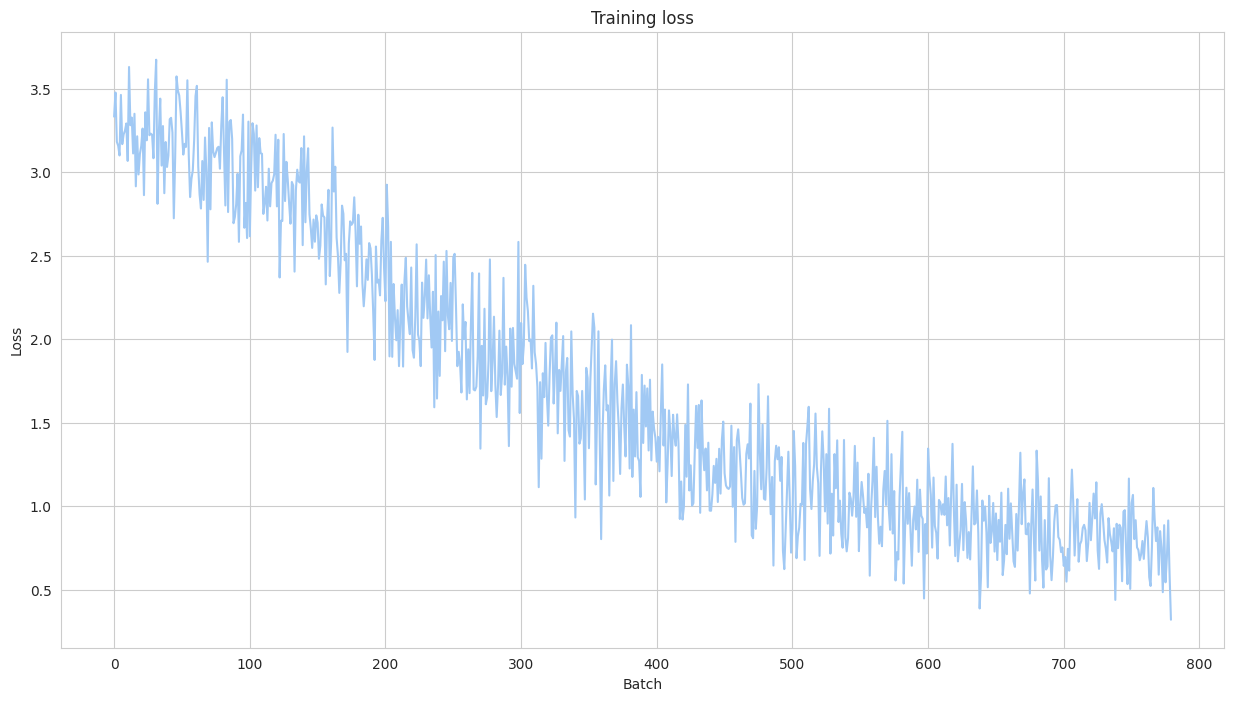

In [55]:
#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [56]:
#@title Predicting and Evaluating Using the Hold-out Dataset
#df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

#start_row = 2000
#end_row = 3000
#nrows = end_row - start_row + 1

# Use skiprows to skip rows up to the start_row (minus 1 because of zero indexing)
# Use nrows to specify the number of rows to read
df_test = pd.read_csv("test_dataset.csv")





In [57]:
df_test.head()

,Category,Resume,Category_orig
0,8,"I am Kamau, I am 27 years old and I am African...",DevOps Engineer
1,23,"I am Alikae, I am 47 years old and I am Americ...",Testing
2,15,"I am Bayard, I am 54 years old and I am French...",Java Developer
3,18,"I am Leola, I am 26 years old and I am America...",Operations Manager
4,3,"I am Akhil, I am 30 years old and I am Indian....",Blockchain


In [58]:
df_test['Resume']=df_test['Resume'].apply(lambda x: clean_resume(x))

In [59]:
# Apply the function to each row
# Apply the function to each row
df_test['Resume'] = df_test.apply(remove_word_case_insensitive, axis=1)

In [60]:
df_test.head()

,Category,Resume,Category_orig
0,8,i am kamau i am 27 years old and i am african ...,DevOps Engineer
1,23,i am alikae i am 47 years old and i am america...,Testing
2,15,i am bayard i am 54 years old and i am french ...,Java Developer
3,18,i am leola i am 26 years old and i am american...,Operations Manager
4,3,i am akhil i am 30 years old and i am indian k...,Blockchain


In [ ]:
#df_test['review'] = df_test['review'].apply(remove_html_tags)
#df_test['review'] = df_test['review'].apply(remove_html_tags)
#df_test['review'] = df_test['review'].apply(remove_url)

# Mapping dictionary


# Apply the mapping to the sentiment column
#df_test['sentiment_numeric'] = df_test['sentiment'].map(label_map)

In [61]:

# Create sentence and label lists
sentences = df_test.Resume.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_test.Category.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 512

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)



prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 4


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [62]:
len(prediction_inputs)
len(prediction_masks)
len(attention_masks)

97

In [63]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [64]:
#@title Evaluating Using Matthew's Correlation Coefficient
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [65]:
#@title Score of Individual Batches
matthews_set

[1.0,
 1.0,
 1.0,
 1.0,
 0.75,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.75,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.75,
 1.0,
 0.0]

## F score

In [66]:
#@title Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.9572194651913956

In [67]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [68]:
print("f1:", f1_score(flat_true_labels, flat_predictions, average='macro'))

f1: 0.9507301587301586


In [69]:
resulting_labels = list(df['Category'].unique())

In [70]:
resulting_labels

[6,
 12,
 0,
 1,
 24,
 16,
 22,
 14,
 5,
 15,
 4,
 21,
 2,
 11,
 18,
 20,
 8,
 17,
 19,
 7,
 13,
 10,
 9,
 3,
 23]

In [71]:
report = classification_report(flat_true_labels, flat_predictions, target_names=
['Advocate', 'Arts', 'Automation Testing', 'Blockchain', 'Business Analyst', 'Civil Engineer', 'Data Science', 'Database', 'DevOps Engineer', 'DotNet Developer', 'ETL Developer',    'Electrical Engineering', 'HR', 'Hadoop', 'Health and fitness', 'Java Developer', 'Mechanical Engineer',  'Network Security Engineer', 'Operations Manager', 'PMO', 'Python Developer',
'SAP Developer', 'Sales', 'Testing', 'Web Designing'])
print(report)

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         2
                     Arts       1.00      1.00      1.00         4
       Automation Testing       1.00      0.33      0.50         3
               Blockchain       1.00      1.00      1.00         4
         Business Analyst       0.75      1.00      0.86         3
           Civil Engineer       1.00      1.00      1.00         2
             Data Science       0.80      1.00      0.89         4
                 Database       1.00      0.67      0.80         3
          DevOps Engineer       0.83      0.83      0.83         6
         DotNet Developer       1.00      1.00      1.00         3
            ETL Developer       1.00      1.00      1.00         4
   Electrical Engineering       1.00      1.00      1.00         3
                       HR       1.00      1.00      1.00         4
                   Hadoop       1.00      1.00      1.00     

In [72]:
import seaborn as sn
import matplotlib.pyplot as plt

In [73]:
def plot_cm(cm):
    #label_0 = negative, label_1 = positive, label_2 = neutral
    classes =  ['Advocate', 'Arts', 'Automation Testing', 'Blockchain', 'Business Analyst', 'Civil Engineer', 'Data Science', 'Database', 'DevOps Engineer', 'DotNet Developer', 'ETL Developer',    'Electrical Engineering', 'HR', 'Hadoop', 'Health and fitness', 'Java Developer', 'Mechanical Engineer',  'Network Security Engineer', 'Operations Manager', 'PMO', 'Python Developer',
'SAP Developer', 'Sales', 'Testing', 'Web Designing']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

In [74]:
cm = confusion_matrix(flat_true_labels, flat_predictions, normalize='true')
cm

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.33333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.33333333, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

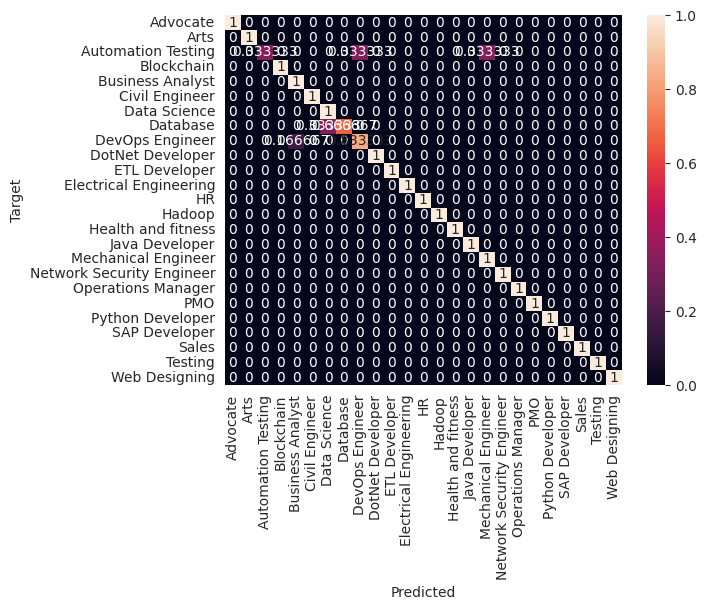

In [75]:
plot_cm(cm)

In [76]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=1467193bc59739482191b86574e3d8a5ac392657b75e8e26fc295571c3b70339
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [77]:
new_input = "I worked 8 years as lawyer and advocate and since 2 years as judge."
#new_input = "advocate"

In [78]:
import torch
from transformers import AutoTokenizer

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Move your model to the chosen device
model.to(device)

# The sentence you want to predict on
sentence = new_input

# Tokenize the sentence and prepare input tensors
inputs = tokenizer(sentence, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Move the input tensors to the same device as the model
inputs = inputs.to(device)

# Put model in evaluation mode
model.eval()

# Predicting without computing gradients
with torch.no_grad():
    # Forward pass, calculate logit predictions. Adjust this call based on your specific model.
    logits = model(**inputs).logits

# Move logits to CPU (if needed) and convert to numpy array
logits = logits.detach().cpu().numpy()

# Here, you can apply any further processing on `logits`, like extracting the predicted class
predicted_class = np.argmax(logits, axis=1)
print("Predicted class:", predicted_class)



Predicted class: [0]


## lime analysis

In [79]:
from transformers import AutoTokenizer
import torch
from lime.lime_text import LimeTextExplainer
import numpy as np

# Assuming 'model' and 'tokenizer' are already defined and configured
# Adjust this function as necessary for your specific model output

def predict_proba(texts):
    model.eval()  # Make sure model is in eval mode
    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            predictions.append(probs)

    return np.array(predictions).squeeze(axis=1)




In [80]:
# Initialize LIME Text Explainer
explainer = LimeTextExplainer(class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])  # Adjust class names as needed

# Example text already defined as 'sentence'
text_to_explain = sentence

# Generate explanation
exp = explainer.explain_instance(text_to_explain, predict_proba, num_features=6)

# Visualize the explanation
# If using Jupyter Notebook, you can use exp.show_in_notebook(text=True)
print(exp.as_list())

# Visualize the explanation (in Jupyter Notebook or similar environment)
exp.show_in_notebook(text=True)


[('advocate', -0.0046827993778180916), ('as', -0.0037999923872188614), ('8', -0.0031188490810192806), ('lawyer', -0.002571264949233293), ('2', -0.0019278193188525606), ('and', 0.00176454810392369)]
